In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [43]:
# Define data augmentation and normalization transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# Get class names and mappings
classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Define animal classes
animal_classes = [1, 3, 4, 15, 21, 27, 30, 31, 34, 38, 42, 43, 44, 50, 72, 73, 78, 88, 93, 97]

# Create label mappings
label_to_new_label = {label: idx for idx, label in enumerate(animal_classes)}
new_label_to_class_name = {idx: idx_to_class[label] for label, idx in label_to_new_label.items()}

# Get indices of animal class samples
train_labels = train_dataset.targets
test_labels = test_dataset.targets

animal_train_indices = [i for i, label in enumerate(train_labels) if label in animal_classes]
animal_test_indices = [i for i, label in enumerate(test_labels) if label in animal_classes]

Files already downloaded and verified
Files already downloaded and verified


In [44]:
# Create custom dataset for animals
class AnimalCIFAR100Dataset(Dataset):
    def __init__(self, subset, label_map):
        self.subset = subset
        self.label_map = label_map

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        new_label = self.label_map[label]
        return img, new_label

# Create animal datasets
train_dataset_animals = AnimalCIFAR100Dataset(Subset(train_dataset, animal_train_indices), label_to_new_label)
test_dataset_animals = AnimalCIFAR100Dataset(Subset(test_dataset, animal_test_indices), label_to_new_label)

# Create data loaders
train_loader = DataLoader(train_dataset_animals, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset_animals, batch_size=64, shuffle=False)

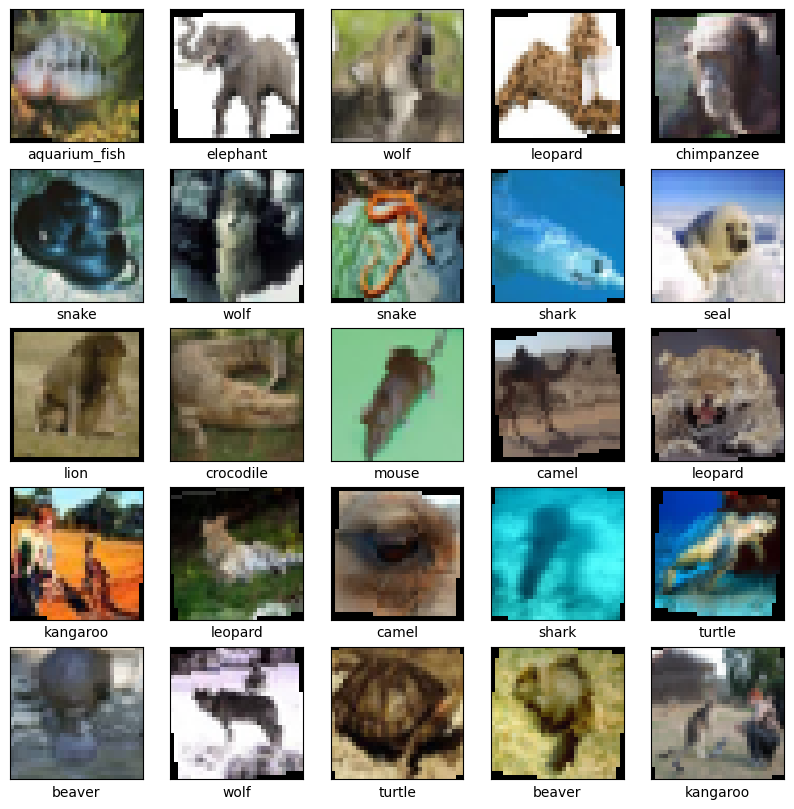

In [45]:
# Visualize some images
images, labels = zip(*[train_dataset_animals[i] for i in range(25)])
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = images[i].numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.xlabel(new_label_to_class_name[labels[i]])
plt.show()

In [46]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes=20):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)  # Output size: (16, 16)
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # Output size: (8, 8)
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # Output size: (4, 4)
        x = self.dropout(x)
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [47]:
# Initialize the model, loss function, and optimizer
model = CNNModel(num_classes=len(animal_classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Device configuration
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS backend")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA backend")
else:
    device = torch.device('cpu')
    print("Using CPU")
model.to(device)


Using MPS backend


CNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=20, bias=True)
)

In [48]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item() * inputs.size(0)

    # Calculate average loss over an epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/100, Loss: 2.7311
Epoch 2/100, Loss: 2.4570
Epoch 3/100, Loss: 2.3641
Epoch 4/100, Loss: 2.3051
Epoch 5/100, Loss: 2.2386
Epoch 6/100, Loss: 2.1874
Epoch 7/100, Loss: 2.1379
Epoch 8/100, Loss: 2.0803
Epoch 9/100, Loss: 2.0382
Epoch 10/100, Loss: 1.9840
Epoch 11/100, Loss: 1.9506
Epoch 12/100, Loss: 1.9157
Epoch 13/100, Loss: 1.8729
Epoch 14/100, Loss: 1.8381
Epoch 15/100, Loss: 1.8110
Epoch 16/100, Loss: 1.7897
Epoch 17/100, Loss: 1.7633
Epoch 18/100, Loss: 1.7376
Epoch 19/100, Loss: 1.7219
Epoch 20/100, Loss: 1.6960
Epoch 21/100, Loss: 1.6675
Epoch 22/100, Loss: 1.6431
Epoch 23/100, Loss: 1.6157
Epoch 24/100, Loss: 1.5956
Epoch 25/100, Loss: 1.6005
Epoch 26/100, Loss: 1.5548
Epoch 27/100, Loss: 1.5467
Epoch 28/100, Loss: 1.5157
Epoch 29/100, Loss: 1.5034
Epoch 30/100, Loss: 1.4920
Epoch 31/100, Loss: 1.4660
Epoch 32/100, Loss: 1.4459
Epoch 33/100, Loss: 1.4444
Epoch 34/100, Loss: 1.4333
Epoch 35/100, Loss: 1.4169
Epoch 36/100, Loss: 1.3904
Epoch 37/100, Loss: 1.3872
Epoch 38/1

In [49]:
# Evaluate the model on test data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.5115


## Testing a pre-trained model (ResNet) using transfer learning

In [50]:
import torch
from torchvision import models

# Device configuration
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
    print("Using MPS backend")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using MPS backend


In [51]:
# Model setup (using ResNet18)
model = models.resnet18(pretrained=True)

# Modify for CIFAR-100 images (32x32)
model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = torch.nn.Identity()

# Replace the final layer
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(animal_classes))

# Move the model to the specified device
model = model.to(device)

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [52]:
# Training loop
num_epochs = 25
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in train_loader:
        # Move inputs and labels to device with correct dtype
        inputs = inputs.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.long)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)

    scheduler.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct.float() / len(train_loader.dataset)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')


Epoch 1/25, Loss: 2.1387, Acc: 0.3525
Epoch 2/25, Loss: 1.4489, Acc: 0.5493
Epoch 3/25, Loss: 1.1304, Acc: 0.6471
Epoch 4/25, Loss: 0.8888, Acc: 0.7207
Epoch 5/25, Loss: 0.7191, Acc: 0.7790
Epoch 6/25, Loss: 0.5765, Acc: 0.8202
Epoch 7/25, Loss: 0.4686, Acc: 0.8578
Epoch 8/25, Loss: 0.3288, Acc: 0.9060
Epoch 9/25, Loss: 0.2878, Acc: 0.9208
Epoch 10/25, Loss: 0.2554, Acc: 0.9335
Epoch 11/25, Loss: 0.2391, Acc: 0.9358
Epoch 12/25, Loss: 0.2185, Acc: 0.9476
Epoch 13/25, Loss: 0.2124, Acc: 0.9469
Epoch 14/25, Loss: 0.2013, Acc: 0.9516
Epoch 15/25, Loss: 0.1892, Acc: 0.9571
Epoch 16/25, Loss: 0.1923, Acc: 0.9539
Epoch 17/25, Loss: 0.1911, Acc: 0.9542
Epoch 18/25, Loss: 0.1893, Acc: 0.9553
Epoch 19/25, Loss: 0.1818, Acc: 0.9583
Epoch 20/25, Loss: 0.1824, Acc: 0.9577
Epoch 21/25, Loss: 0.1831, Acc: 0.9580
Epoch 22/25, Loss: 0.1774, Acc: 0.9582
Epoch 23/25, Loss: 0.1746, Acc: 0.9608
Epoch 24/25, Loss: 0.1765, Acc: 0.9599
Epoch 25/25, Loss: 0.1758, Acc: 0.9602


### Uncomment this for running a previously saved model

In [53]:
# # Re-instantiate the model architecture
# model = models.resnet18(pretrained=False)

# # Modify for CIFAR-100 images (32x32)
# model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
# model.maxpool = torch.nn.Identity()

# # Replace the final layer
# num_ftrs = model.fc.in_features
# model.fc = torch.nn.Linear(num_ftrs, len(animal_classes))

# # Load the saved state dictionary
# model.load_state_dict(torch.load('animal_classifier.pth'))

# # Move the model to the desired device
# model = model.to(device)

# print("Model loaded successfully.")

In [54]:
# Test the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.long)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.7110


### Uncomment this if you want to save the model for later use

In [55]:
# model_path = 'animal_classifier_2.pth'

# # Save the state dictionary

# torch.save(model.state_dict(), model_path)

# print(f'Model saved to {model_path}')